<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/tutorialParetoOptimality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Optimization of Autonomous Bus Stops
## Game Theory and Multi-Objective Optimization


**Context:** An autonomous bus must determine its optimal stops in a city organized in a 10×10 grid. Ten passengers inside the bus have different preferences for the stops. What are the Pareto optima and the nash equilibria ?


In [2]:
#few libraries
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import cityblock
import random
from typing import List, Tuple, Set
from dataclasses import dataclass

### Model
Model of the travellers and their preferences

In [3]:
@dataclass
class PointPreference:
    """ a preferred point and its value"""
    x: int
    y: int
    value: float
    
    def position(self) -> Tuple[int, int]:
        return (self.x, self.y)
    
    def __repr__(self):
        """
        string representation of a preferred point.
        """
        return f"PointPreference ({self.x},{self.y})={self.value:.2f}"

In [4]:
class Passenger:
    """
    Model of a traveler with his stop preferences
    """
    def __init__(self, id_passager: int, preferences: List[PointPreference]):
        self.id = id_passager
        # sort preferred points by value descending
        self.preferences = sorted(preferences, key=lambda p: p.value, reverse=True)
        
    def compute_point_utility(self, x: int, y: int, distance_max: float = 20) -> float:
        """
        Compute the utility of any point for this passenger. 
        The value decreases linearly with the distance to the nearest preferred point.
        
        Args:
            x, y: coordinates of the point to evaluate
            distance_max: distance at which the utility becomes zero
        """
        # is it a preferred point?
        for pref in self.preferences:
            if pref.x == x and pref.y == y:
                return pref.value
        
        # not a preferred point, compute utility based on distance to preferred points
        max_utility = 0
        for pref in self.preferences:
            #use cityblock (=manhattan, laplacian) distance because city is a grid
            dist = cityblock((x, y), (pref.x, pref.y))
            utility = max(0, pref.value * (1 - dist / distance_max))
            max_utility = max(max_utility, utility)
        
        return max_utility
    
    def compute_max_utility(self, stops: Set[Tuple[int, int]]) -> float:
        """
        Compute the max utility for a given set of stops.
        Takes the best available stop because, only 1 stop will be used.
        """
        # no stops provided -> utility is zero
        if not stops: return 0.0
        
        utilities = [self.compute_point_utility(x, y) for x, y in stops]
        return max(utilities)
    
    def compute_min_utility(self, stops: Set[Tuple[int, int]]) -> float:
        """
        Compute the min utility for a given set of stops.
        Takes the worst available stop because, only 1 stop will be used.
        """
        # no stops provided -> utility is zero
        if not stops: return 0.0
        
        utilities = [self.compute_point_utility(x, y) for x, y in stops]
        return min(utilities)

    def __repr__(self):
        """
        string representation of a passenger.
        """
        points_str = ', '.join([str(p) for p in self.preferences])
        return f"Passager {self.id} - Prefs=[{points_str}]"

In [5]:
# Example usage
p = Passenger(1,  [PointPreference(2, 2, 10), PointPreference(5, 5, 5)])
point = {"x": 2, "y": 2}
print("",point, " : utility =  ", p.compute_point_utility(point["x"], point["y"]))  
point = {"x": 3, "y": 3}
print("",point, " : utility =  ", p.compute_point_utility(point["x"], point["y"]))  
point = {"x": 5, "y": 4}
print("",point, " : utility =  ", p.compute_point_utility(point["x"], point["y"]))  
point = {"x": 5, "y": 5}
print("",point, " : utility =  ", p.compute_point_utility(point["x"], point["y"]))  
print("max utility for these points =  ", p.compute_max_utility({(2, 2), (3, 3), (5, 4), (5, 5)}))  
print("min utility for these points =  ", p.compute_min_utility({(2, 2), (3, 3), (5, 4), (5, 5)}))  


 {'x': 2, 'y': 2}  : utility =   10
 {'x': 3, 'y': 3}  : utility =   9.0
 {'x': 5, 'y': 4}  : utility =   7.5
 {'x': 5, 'y': 5}  : utility =   5
max utility for these points =   10
min utility for these points =   5


----
#### Data generation

Let's generate passengers..

In [6]:
def generate_random_passengers(nbp: int = 10, grid_size: int = 10,  seed: int = 42) -> List[Passenger]:
    """
    Generates np passengers with coherent random preferences.
    
    Args:
        np: nb of passengers to generate avoiding the first quadrant
        grid_size:  (10x10 par défaut)
        seed: seed for random generator (start value for the sequence of random numbers)
    """
    random.seed(seed)
    
    passengers = []
    quart = grid_size // 4
    
    for i in range(nbp):
        
        # generate 3 distinct preferred points
        chosen_points = set()
        preferences = []
        
        # generate 3 random values, sorted descending
        valeurs = sorted([random.uniform(50, 100), 
                         random.uniform(30, 70), 
                         random.uniform(10, 50)], reverse=True)
        
        for valeur in valeurs:
            # avoid choosing the same point twice (only 3 points among 100 possible, so the loop will end quickly)
            while True:
                x = random.randint(quart, grid_size - 1)
                y = random.randint(quart, grid_size - 1)
                if (x, y) not in chosen_points:
                    chosen_points.add((x, y))
                    break
            
            preferences.append(PointPreference(x, y, valeur))
        
        passengers.append(Passenger(i,  preferences))
    
    return passengers


In [7]:
# Example usage
passengers = generate_random_passengers(3, 10, 42)
for p in passengers: print(p)

Passager 0 - Prefs=[PointPreference (5,4)=81.97, PointPreference (3,3)=31.00, PointPreference (8,2)=21.00]
Passager 1 - Prefs=[PointPreference (2,5)=51.49, PointPreference (8,5)=38.75, PointPreference (9,6)=30.21]
Passager 2 - Prefs=[PointPreference (8,7)=90.47, PointPreference (6,4)=42.23, PointPreference (5,7)=30.26]


In [8]:
#function that can be used or not to compute max utilities of a set of stops for all passengers, 
def compute_max_utilities(stops: Set[Tuple[int, int]],  passengers: List[Passenger]) -> np.ndarray:
    """
    compute utilities vector for all passengers   
    Args:
        stops:  selected stops set 
        passengers:  passengers list
    Returns:
        Array of len(passengers) with  individual utilities
    """
    return np.array([p.compute_max_utility(stops) for p in passengers])

#function that can be used or not to compute min utilities of a set of stops for all passengers, 
def compute_min_utilities(stops: Set[Tuple[int, int]],  passengers: List[Passenger]) -> np.ndarray:
    """
    compute utilities vector for all passengers   
    Args:
        stops:  selected stops set 
        passengers:  passengers list
    Returns:
        Array of len(passengers) with  individual utilities
    """
    return np.array([p.compute_min_utility(stops) for p in passengers])


In [9]:
# Example usage
passengers = generate_random_passengers(5, 10, 42)
for p in passengers: print(p)
stops = {(2, 2), (5, 5), (7, 7)}
print("Proposed stops: ", stops)
max_utilities = compute_max_utilities(stops, passengers)
min_utilities = compute_min_utilities(stops, passengers)
print("Interests of the points for the passengers")
i = 0
for p in passengers: 
    print(f"- passenger{p.id}, utility (= max utility) = : {max_utilities[i]:.2f}")
    i+=1


Passager 0 - Prefs=[PointPreference (5,4)=81.97, PointPreference (3,3)=31.00, PointPreference (8,2)=21.00]
Passager 1 - Prefs=[PointPreference (2,5)=51.49, PointPreference (8,5)=38.75, PointPreference (9,6)=30.21]
Passager 2 - Prefs=[PointPreference (8,7)=90.47, PointPreference (6,4)=42.23, PointPreference (5,7)=30.26]
Passager 3 - Prefs=[PointPreference (7,6)=55.11, PointPreference (2,9)=45.20, PointPreference (3,8)=24.36]
Passager 4 - Prefs=[PointPreference (7,5)=53.94, PointPreference (3,2)=41.73, PointPreference (5,6)=35.15]
Proposed stops:  {(5, 5), (7, 7), (2, 2)}
Interests of the points for the passengers
- passenger0, utility (= max utility) = : 77.87
- passenger1, utility (= max utility) = : 43.77
- passenger2, utility (= max utility) = : 85.95
- passenger3, utility (= max utility) = : 52.35
- passenger4, utility (= max utility) = : 48.55


---
### Paretos points


To find the pareto points (front), we have to check all the possible deal points (10x10 here).
So each passenger has to valuate all of the 100 points.
Next, we have to find the list of Pareto optimal points (a pareto optimal point is not dominated by any other point).


Define the function that determinate if a point is a Pareto point or not.

N.B. *allStops* a set of set of 3 points *p* where the bus can stop.
Each passenger have their preference on this proposal.

Let *busStop* a set of 3 points.

- *busStop* is Pareto-optimal ⟺ ∄ *OtherStops* such as *OtherStops* dominates *busStop*
   -  *OtherStops* dominates *busStop* if (Ui​(*OtherStops*)≥Ui​(*busStop*) ∀i) and (Ui​(*OtherStops*)>Ui​(*busStop*) for at least one i)
   -  i = passenger i


In [10]:
def is_pareto_optimal(stop: Tuple[int, int], all_points: List[Set[Tuple[int, int]]], passengers: List[Passenger]) -> bool:
    """"
    Determine if a given stop_set is Pareto optimal among all_sets for the given passengers.
    Args:
        stop: The stop to evaluate.
        all_points: List of all possible  stops.
        passengers: List of passengers.
    """
    utilities_stop = compute_max_utilities(stop, passengers)

    for other_stop in all_points:
        if other_stop == stop: continue
        utilities_other = compute_max_utilities(other_stop, passengers)
        # Check if other_stop dominates stop
        if np.all(utilities_other >= utilities_stop) and np.any(utilities_other > utilities_stop):
            return False
        
    return True

#### Tests 
Generate a list of set of 3 stop; and find the pareto optimal ones (if there exists any).

Display them and their utilities for the passengers.


In [11]:
# Example usage
passengers = []
passengers.append(Passenger(1,  [PointPreference(0, 0, 10), PointPreference(3, 3, 5)]))
passengers.append(Passenger(2,  [PointPreference(0, 1, 10), PointPreference(3, 4, 5)]))
passengers.append(Passenger(3,  [PointPreference(1, 0, 10), PointPreference(4, 3, 5)]))
passengers.append(Passenger(4,  [PointPreference(1, 2, 10), PointPreference(4, 4, 5)]))
passengers.append(Passenger(5,  [PointPreference(2, 1, 10), PointPreference(2, 4, 5)]))

all_stops = []
for k in range(4):
    stops = [(6+i, 5+k) for i in range(3)]
    all_stops.append(stops)

all_stops.append([(2,2),(2,0), (2,1)])

print("Passengers:")
for p in passengers: print(p)
print("All possible stops: ", all_stops)

print("Pareto optimality of each stop:")
for stop in all_stops:
    pareto_opt = is_pareto_optimal(stop, all_stops, passengers)
    print(f"- Stop {stop} is Pareto optimal: {pareto_opt}")

Passengers:
Passager 1 - Prefs=[PointPreference (0,0)=10.00, PointPreference (3,3)=5.00]
Passager 2 - Prefs=[PointPreference (0,1)=10.00, PointPreference (3,4)=5.00]
Passager 3 - Prefs=[PointPreference (1,0)=10.00, PointPreference (4,3)=5.00]
Passager 4 - Prefs=[PointPreference (1,2)=10.00, PointPreference (4,4)=5.00]
Passager 5 - Prefs=[PointPreference (2,1)=10.00, PointPreference (2,4)=5.00]
All possible stops:  [[(6, 5), (7, 5), (8, 5)], [(6, 6), (7, 6), (8, 6)], [(6, 7), (7, 7), (8, 7)], [(6, 8), (7, 8), (8, 8)], [(2, 2), (2, 0), (2, 1)]]
Pareto optimality of each stop:
- Stop [(6, 5), (7, 5), (8, 5)] is Pareto optimal: False
- Stop [(6, 6), (7, 6), (8, 6)] is Pareto optimal: False
- Stop [(6, 7), (7, 7), (8, 7)] is Pareto optimal: False
- Stop [(6, 8), (7, 8), (8, 8)] is Pareto optimal: False
- Stop [(2, 2), (2, 0), (2, 1)] is Pareto optimal: True


In [12]:
def get_pareto_optimal(all_points: List[Set[Tuple[int, int]]], passengers: List[Passenger]) -> List[Set[Tuple[int, int]]]:
    """"
    Compute Pareto optimal point among all_sets for the given passengers.
    Args:
        all_points: List of all possible  stops.
        passengers: List of passengers.
    """
    pareto_points = []
    for stop in all_points:
        if is_pareto_optimal(stop, all_points, passengers):
            pareto_points.append(stop)
    
    return pareto_points

In [13]:
# Example usage
print("in the set of all set of 3 stops, the Pareto optimal stops are:")
print(get_pareto_optimal(all_stops, passengers))

in the set of all set of 3 stops, the Pareto optimal stops are:
[[(2, 2), (2, 0), (2, 1)]]


In [20]:
#10 persons in a shuttle
nb_passengers = 10
passengers = generate_random_passengers(nb_passengers, 10, 42)
all_stops = []
grid_size = 10
nb_stops_set = 20
#20 possibilities of 3 stops
for i in range(nb_stops_set):
    triplet = []
    for j in range(3):
        while True:
            x = random.randint(0, grid_size - 1)
            y = random.randint(0, grid_size - 1)
            if (x, y) not in triplet:
                triplet.append((x, y))
                break
    all_stops.append(triplet)
print(f"Generated {nb_passengers} passengers with random preferences.")
for p in passengers: print(p)
print(f"Generated {nb_stops_set} possible sets of 3 stops.")
print( all_stops)
optimal_points = get_pareto_optimal(all_stops, passengers)
print(f"From {nb_stops_set} stops set, found {len(optimal_points)}  Pareto optimal stops :")
for stop in optimal_points:
    print(stop)
print("now we need a politic to select one of these optimal stops.")


Generated 10 passengers with random preferences.
Passager 0 - Prefs=[PointPreference (5,4)=81.97, PointPreference (3,3)=31.00, PointPreference (8,2)=21.00]
Passager 1 - Prefs=[PointPreference (2,5)=51.49, PointPreference (8,5)=38.75, PointPreference (9,6)=30.21]
Passager 2 - Prefs=[PointPreference (8,7)=90.47, PointPreference (6,4)=42.23, PointPreference (5,7)=30.26]
Passager 3 - Prefs=[PointPreference (7,6)=55.11, PointPreference (2,9)=45.20, PointPreference (3,8)=24.36]
Passager 4 - Prefs=[PointPreference (7,5)=53.94, PointPreference (3,2)=41.73, PointPreference (5,6)=35.15]
Passager 5 - Prefs=[PointPreference (8,6)=99.26, PointPreference (9,7)=64.21, PointPreference (4,7)=44.66]
Passager 6 - Prefs=[PointPreference (3,4)=67.76, PointPreference (5,4)=56.81, PointPreference (9,8)=38.07]
Passager 7 - Prefs=[PointPreference (5,7)=67.02, PointPreference (2,5)=63.50, PointPreference (2,7)=37.53]
Passager 8 - Prefs=[PointPreference (7,5)=70.06, PointPreference (9,8)=46.53, PointPreference (

---
#### Social choice
We have a set of Pareto equilibrium. We need a politic to select one.

Here, we use  social choice function to select one among these optimal stops, so the set of three stops that maximize the minimum value among all passengers

Selected stop set maximizing the minimum utility among all passengers:  [(2, 6), (9, 1), (6, 6)]
Interests of the selected stop set for the passengers
- passenger0, utility (= max utility) = : 69.68
- passenger1, utility (= max utility) = : 48.92
- passenger2, utility (= max utility) = : 76.90
- passenger3, utility (= max utility) = : 52.35
- passenger4, utility (= max utility) = : 48.55
- passenger5, utility (= max utility) = : 89.33
- passenger6, utility (= max utility) = : 57.60
- passenger7, utility (= max utility) = : 60.32
- passenger8, utility (= max utility) = : 63.05
- passenger9, utility (= max utility) = : 56.92


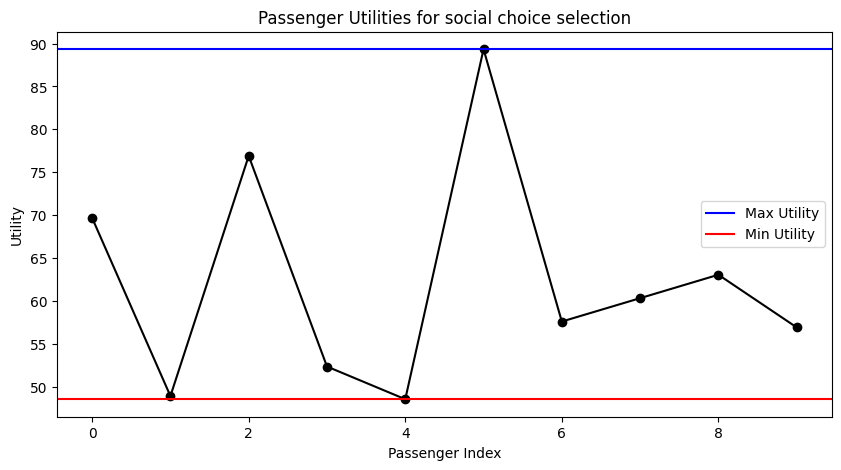

In [ ]:
best_stop = None
best_min_utility = -1
#TODO: select the stop set that maximizes the minimum utility among all passengers


#plot the max and min utilities for each passenger
plt.figure(figsize=(10, 5))
plt.plot(range(nb_passengers), max_utilities, color='black', marker='o')
plt.axhline(y=max(max_utilities), color='b', linestyle='-', label='Max Utility')
plt.axhline(y=min(max_utilities), color='r', linestyle='-', label='Min Utility')
plt.title('Passenger Utilities for social choice selection')
plt.xlabel('Passenger Index')
plt.ylabel('Utility')
plt.legend()

#### Utilitary choice
If we choose the utilitary choice, we select the stops that maximize the sum of the utilities.

Selected stop set maximizing the sum of utilities among all passengers:  [(9, 6), (3, 8), (3, 4)]
- passenger0, utility (= max utility) = : 73.77
- passenger1, utility (= max utility) = : 46.34
- passenger2, utility (= max utility) = : 81.42
- passenger3, utility (= max utility) = : 49.60
- passenger4, utility (= max utility) = : 45.85
- passenger5, utility (= max utility) = : 94.30
- passenger6, utility (= max utility) = : 67.76
- passenger7, utility (= max utility) = : 57.15
- passenger8, utility (= max utility) = : 59.55
- passenger9, utility (= max utility) = : 53.76


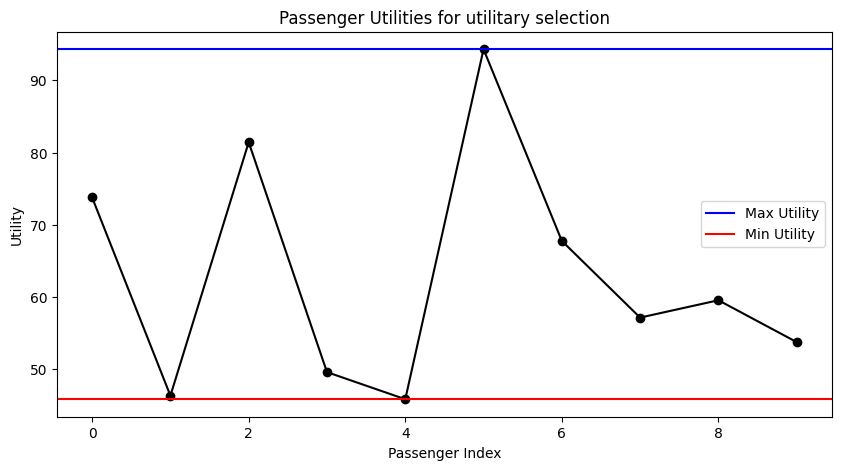

In [ ]:
#  utilitary choice, the stops that maximize the sum of the utilities.
best_stop = None
best_sum_utility = -1
#TODO: select the stop set that maximizes the sum of utilities among all passengers


plt.figure(figsize=(10, 5))
plt.plot(range(nb_passengers), max_utilities, color='black', marker='o')
plt.axhline(y=max(max_utilities), color='b', linestyle='-', label='Max Utility')
plt.axhline(y=min(max_utilities), color='r', linestyle='-', label='Min Utility')
plt.title('Passenger Utilities for utilitary selection')
plt.xlabel('Passenger Index')
plt.ylabel('Utility')
plt.legend()

---
### Nash Equilibria

Now, find stop sets where no passenger can improve their utility by unilaterally changing their preferred stop (definition of Nash equilibria).



- The bus will propose a set of three stops.
- Each passengers will vote among these triplets.
- If the stops in the preferences in each passengers are sorted by value... The triplet that receive the majority of vote should be a Nash equilibrium

Propose a voting strategy for that.
 

In [17]:
# tips
passengers = generate_random_passengers(5, 10, 42)
for p in passengers: print(p)
stops1 = {(2, 2), (5, 5), (7, 7)}
print("Proposed stops: ", stops1)
max_utilities1 = compute_max_utilities(stops1, passengers)
min_utilities1 = compute_min_utilities(stops1, passengers)
print("Interests of the points for the passengers")
print(f" max utility: {max_utilities1}, min utility: {min_utilities1}")
stops2 = {(1, 1), (2, 5), (9, 6)}
print("Proposed stops: ", stops2)
max_utilities2 = compute_max_utilities(stops2, passengers)
min_utilities2 = compute_min_utilities(stops2, passengers)
print("Interests of the points for the passengers")
print(f" max utility: {max_utilities2}, min utility: {min_utilities2}")
print(f" max_utilities1 -max_utilities2 = ", max_utilities1 -max_utilities2 )


Passager 0 - Prefs=[PointPreference (5,4)=81.97, PointPreference (3,3)=31.00, PointPreference (8,2)=21.00]
Passager 1 - Prefs=[PointPreference (2,5)=51.49, PointPreference (8,5)=38.75, PointPreference (9,6)=30.21]
Passager 2 - Prefs=[PointPreference (8,7)=90.47, PointPreference (6,4)=42.23, PointPreference (5,7)=30.26]
Passager 3 - Prefs=[PointPreference (7,6)=55.11, PointPreference (2,9)=45.20, PointPreference (3,8)=24.36]
Passager 4 - Prefs=[PointPreference (7,5)=53.94, PointPreference (3,2)=41.73, PointPreference (5,6)=35.15]
Proposed stops:  {(5, 5), (7, 7), (2, 2)}
Interests of the points for the passengers
 max utility: [77.87277293 43.76638183 85.94794669 52.35498813 48.54600891], min utility: [61.47850494 33.46840963 40.71218528 30.3107826  39.64077469]
Proposed stops:  {(1, 1), (2, 5), (9, 6)}
Interests of the points for the passengers
 max utility: [65.57707194 51.48986097 81.42437055 49.59946244 45.84900842], min utility: [53.28137095 30.21421152 31.66503299 24.85840061 35.4


=== Analyse des préférences ===

Passager 0:
  Série 0: utilité 77.87 (meilleur arrêt: (5, 3))
  Série 1: utilité 69.68 (meilleur arrêt: (3, 5))
  Série 2: utilité 69.68 (meilleur arrêt: (5, 1))
  Classement: Série 0 > Série 1 > Série 2

Passager 1:
  Série 0: utilité 48.92 (meilleur arrêt: (3, 5))
  Série 1: utilité 48.92 (meilleur arrêt: (3, 5))
  Série 2: utilité 51.49 (meilleur arrêt: (2, 5))
  Classement: Série 2 > Série 0 > Série 1

Passager 2:
  Série 0: utilité 85.95 (meilleur arrêt: (7, 7))
  Série 1: utilité 58.81 (meilleur arrêt: (3, 5))
  Série 2: utilité 85.95 (meilleur arrêt: (9, 7))
  Classement: Série 0 > Série 2 > Série 1

Passager 3:
  Série 0: utilité 52.35 (meilleur arrêt: (7, 7))
  Série 1: utilité 41.33 (meilleur arrêt: (3, 5))
  Série 2: utilité 46.84 (meilleur arrêt: (9, 7))
  Classement: Série 0 > Série 2 > Série 1

Passager 4:
  Série 0: utilité 48.55 (meilleur arrêt: (7, 7))
  Série 1: utilité 43.15 (meilleur arrêt: (3, 5))
  Série 2: utilité 43.15 (meilleur